In [1]:
import numpy as np
import matplotlib.pyplot as plt
import muram as mio
from astropy.io import fits
import pyflct
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
from matplotlib import font_manager
import matplotlib as mpl
font_path = '/home/mistflow/.fonts/cmunrm.ttf'  # Your font path goes here
#font_path = '/usr/share/fonts/opentype/urw-base35/NimbusRoman-Italic.otf'
font_manager.fontManager.addfont(font_path)
prop = font_manager.FontProperties(fname=font_path)
mpl.rcParams["font.size"] = 12
mpl.rcParams['axes.formatter.useoffset'] = False
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = prop.get_name()
#plt.rc('text', usetex=True)
plt.rc('axes', unicode_minus=False)

In [3]:
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from scipy.stats import linregress

In [4]:
def temporal_avg(data_in, start, end):
    tmp_avg = np.mean(data_in[start:end+1], axis = 0)
    return tmp_avg

In [5]:
def mean_v_from_file(file):
    v_x = fits.open(file)[0].data
    v_x.shape
    v_x = v_x[0:90]
    v_x = np.mean(v_x, axis=0)
    small = np.where(v_x < -6.5)
    v_x[small] = -6.5
    big = np.where(v_x > 6.5)
    v_x[big] = 6.5
    return v_x

def mean_vy_from_file(file):
    v_x = fits.open(file)[1].data
    v_x.shape
    v_x = v_x[0:90]
    v_x = np.mean(v_x, axis=0)
    small = np.where(v_x < -6.5)
    v_x[small] = -6.5
    big = np.where(v_x > 6.5)
    v_x[big] = 6.5
    return v_x

<h3>27. 02. 2025.</h3>

<h2>Basic plots and visualization</h2>

In [6]:
cube = fits.open("loc_dyn_32_32_16_150_tumag.fits")[0].data

In [7]:
np.shape(cube) #768 pixels [x], 768 pixels [y], 4 [Stokes parameters], 622 [wavelengths]

(768, 768, 4, 622)

In [8]:
I_qs = np.mean(cube[:,:,0,:])

In [9]:
print(I_qs)

310445030634039.6


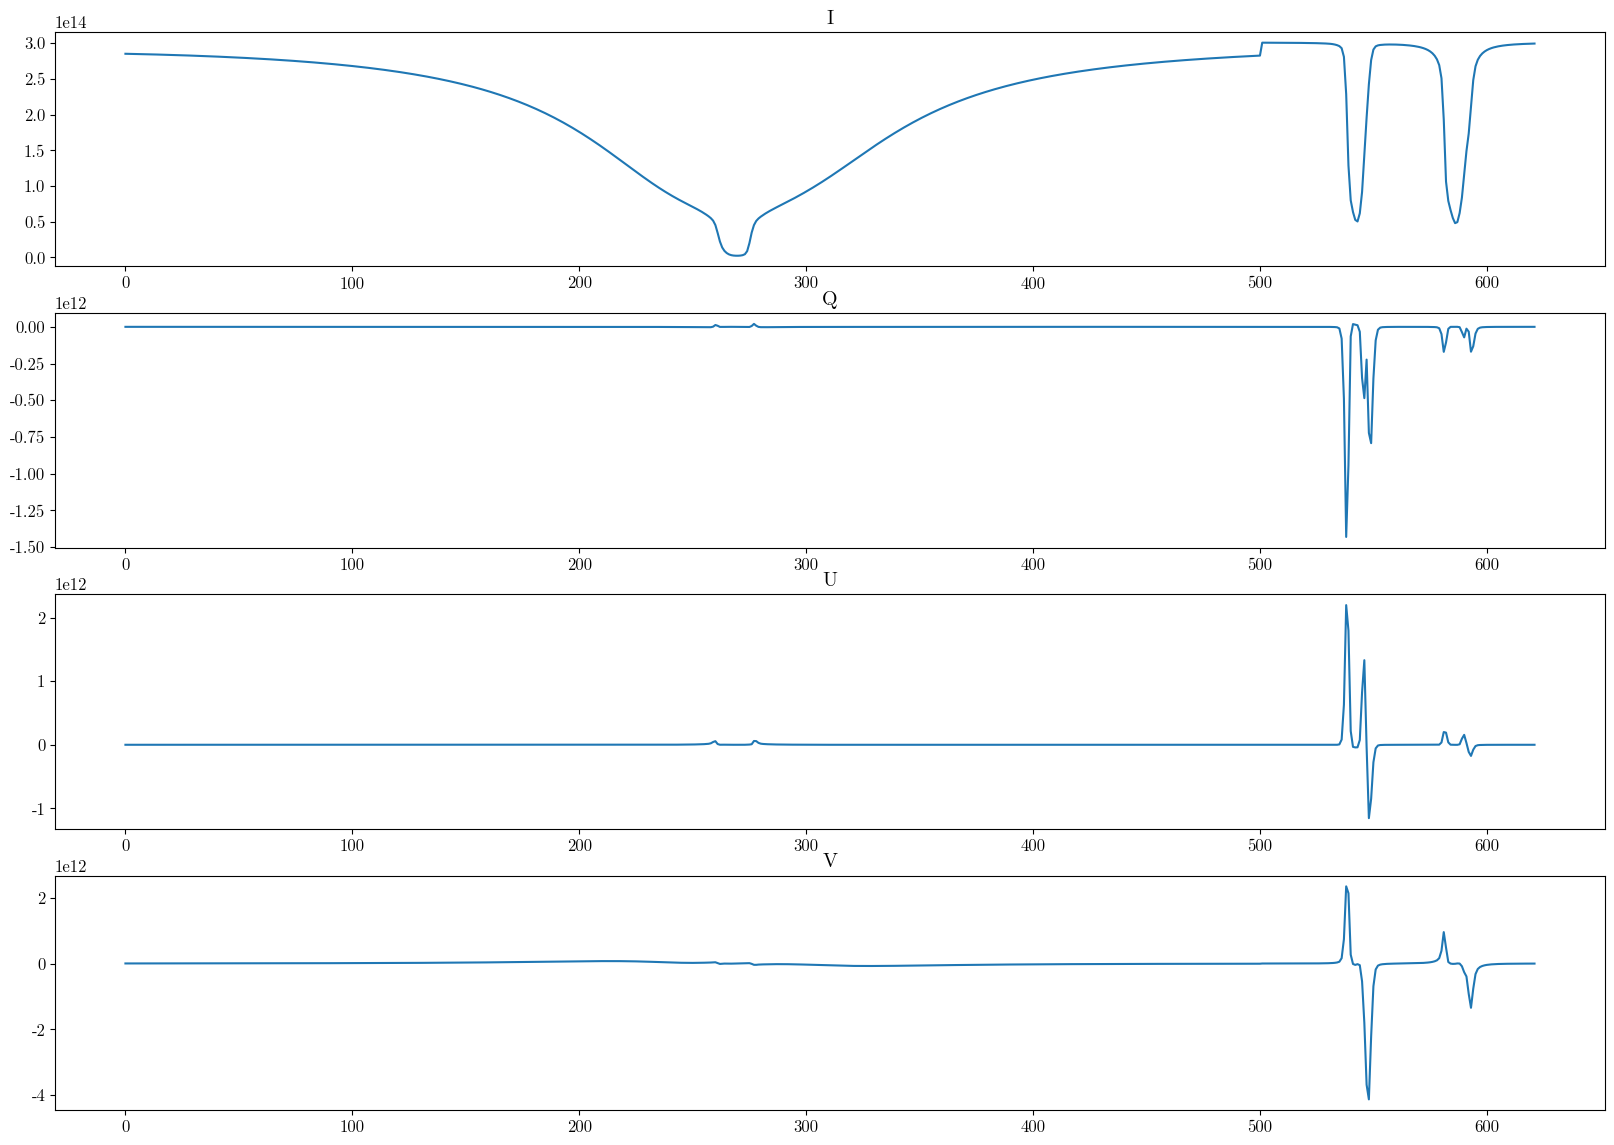

In [10]:
plt.figure(figsize=(20,14))
plt.subplot(4,1,1)
plt.plot(cube[1,1,0,:])
plt.title("I")
#plt.colorbar(label='vx [km/s]')

plt.subplot(4,1,2)
plt.plot(cube[1,1,1,:])
plt.title("Q")
#plt.colorbar(label='T [K]')

plt.subplot(4,1,3)
plt.plot(cube[1,1,2,:])
plt.title("U")
#plt.colorbar(label='Bx [G]')

plt.subplot(4,1,4)
plt.plot(cube[1,1,3,:])
plt.title("V")

plt.show()

<h3>Plotting Stokes parameters</h3>

In [11]:
levels = [0, 261, 537]
lambdasI = []
lambdasQ = []
lambdasV = []
for level in levels:
    lambdasI.append(cube[:,:,0,level])
    lambdasQ.append(cube[:,:,1,level])
    lambdasV.append(cube[:,:,3,level])

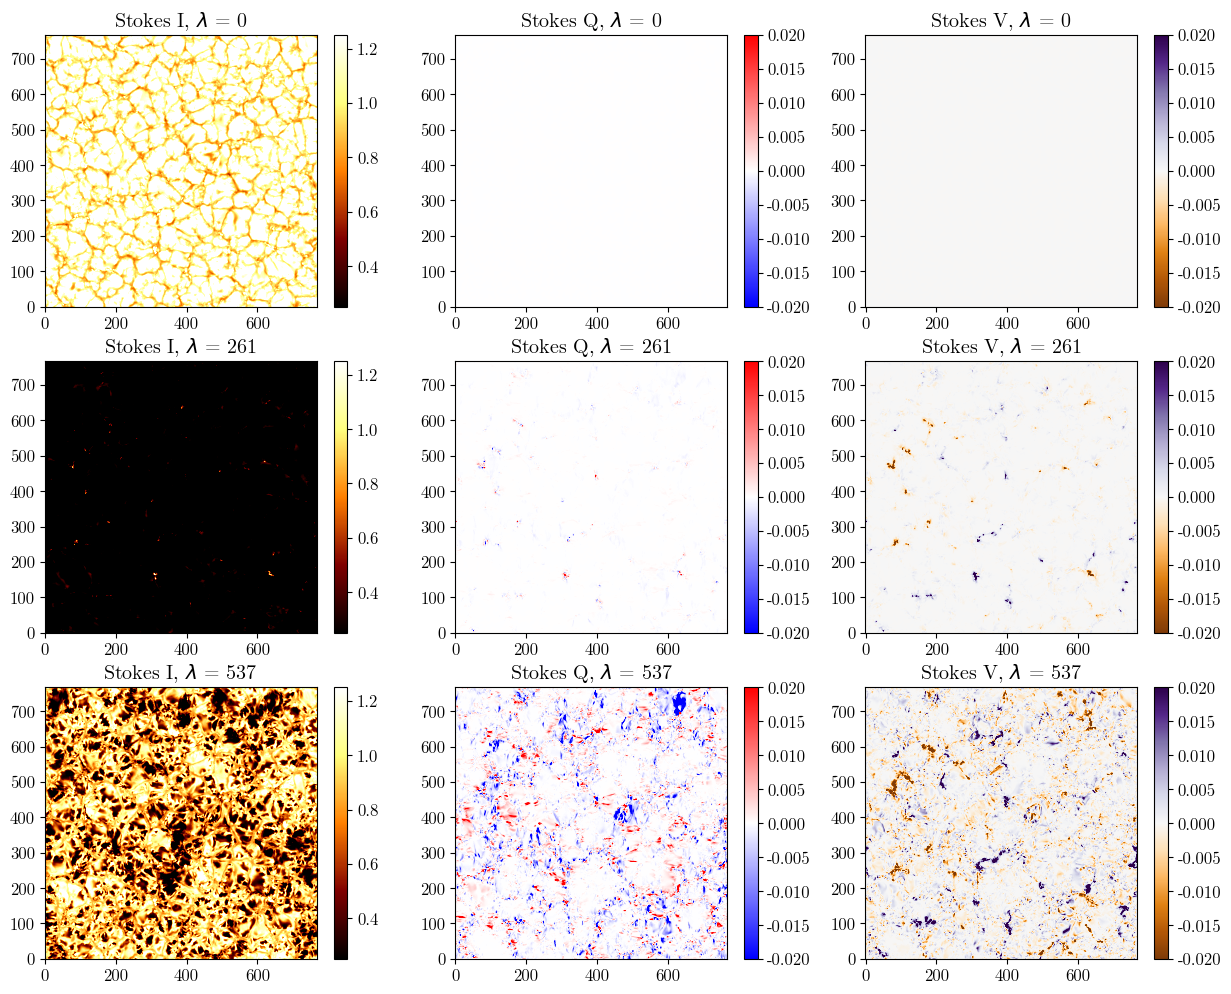

In [15]:
nlevels=len(levels)
plt.figure(figsize=(15,4*nlevels))
for i in range(0, nlevels):
    plt.subplot(nlevels,3,1+3*i)
    plt.imshow((lambdasI[i]/I_qs).T, cmap = 'afmhot', origin='lower', vmin = 0.25, vmax = 1.25)
    plt.colorbar()
    plt.title(f"Stokes I, $\lambda$ = {levels[i]}")
    plt.subplot(nlevels,3,2+3*i)
    plt.imshow((lambdasQ[i]/I_qs).T, cmap = 'bwr', origin='lower', vmin = -0.02, vmax = 0.02)
    plt.title(f"Stokes Q, $\lambda$ = {levels[i]}")
    plt.colorbar()
    plt.subplot(nlevels,3,3+3*i)
    plt.imshow((lambdasV[i]/I_qs).T, cmap = 'PuOr', origin='lower', vmin = -0.02, vmax = 0.02)
    plt.title(f"Stokes V, $\lambda$ = {levels[i]}")
    plt.colorbar()
plt.show()

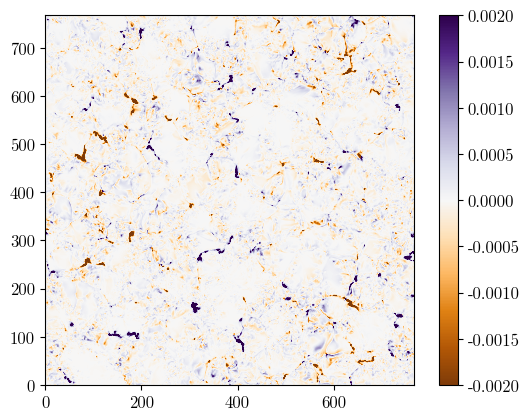

In [13]:
plt.imshow((cube[:,:,3,237]/I_qs).T, origin = "lower", cmap = "PuOr", vmin = -0.002, vmax = 0.002)
plt.colorbar()

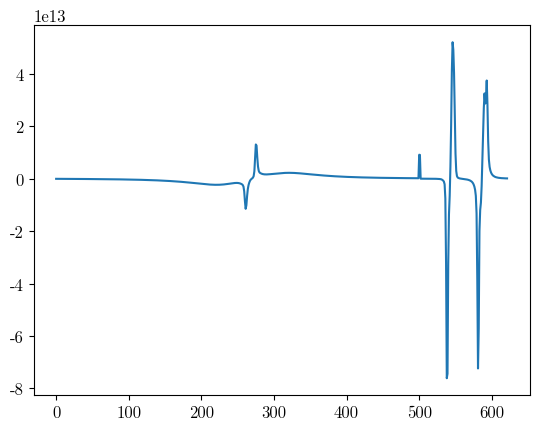

In [14]:
plt.plot(np.gradient(cube[1,1,0,:])) # Stokes V is proportional to gradient of normal component of Bz

<h3>Milne-Eddington inversion vs. tau_slices $[B_z]$</h3>

In [39]:
# Bz na log tau = -1
Bz_tm1 = fits.open("Bz_0_100.fits")[0].data
Bz_tm1 = Bz_tm1[:, ::2, ::2]
# Bz na log tau = 2
Bz_tm2 = fits.open("Bz_0_010.fits")[0].data
Bz_tm2 = Bz_tm2[:, ::2, ::2]

In [47]:
Bz_tm1 = Bz_tm1.transpose(0, 2, 1)
Bz_tm2 = Bz_tm2.transpose(0, 2, 1)

In [48]:
# ME inversion of snapi line
me = fits.open("meinv_tumag_0.fits")[0].data

In [49]:
np.shape(me)

(768, 768, 9)

In [50]:
Bz_ME = me[:,:,0] * np.cos(me[:,:,1])

<h2>Let's compare them as is</h2>

In [51]:
R_m1_base = pearsonr(Bz_tm1[0].flatten(), Bz_ME.flatten())
print(R_m1_base)

PearsonRResult(statistic=0.8302264343706105, pvalue=0.0)


Text(0.5, 1.0, 'ME inversion')

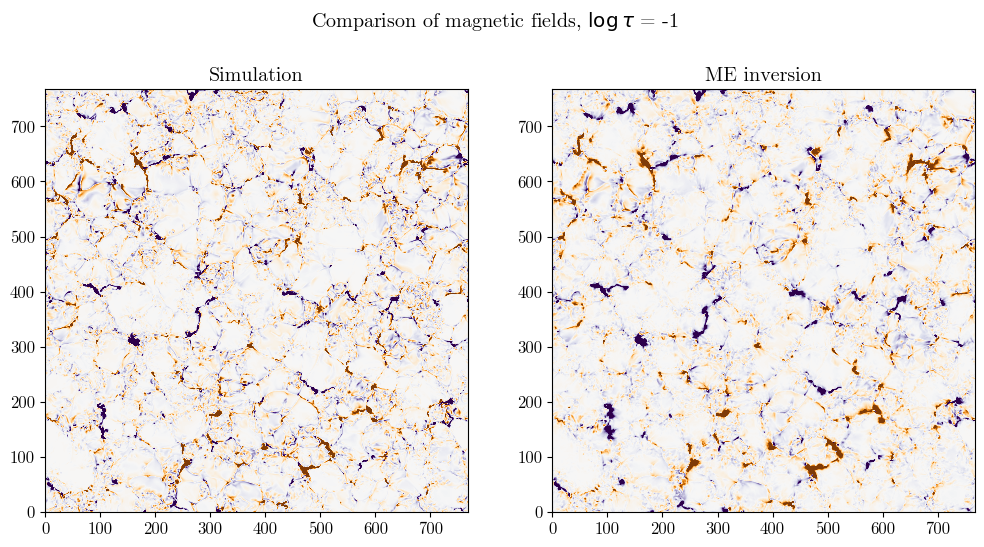

In [54]:
# Comparison of these two methods
fig = plt.figure(figsize = (12,6))
fig.suptitle("Comparison of magnetic fields, $\log\\tau$ = -1")
ax1 = fig.add_subplot(121)
ax1.imshow(Bz_tm1[0,:,:], origin='lower',cmap='PuOr', vmin = -200, vmax = 200)
ax1.set_title("Simulation") 

ax2 = fig.add_subplot(122)
ax2.imshow(Bz_ME[:,:], origin='lower', cmap='PuOr', vmin = -200, vmax = 200)
ax2.set_title("ME inversion") 


In [55]:
R_m2_base = pearsonr(Bz_tm2[0].flatten(), Bz_ME.flatten())
print(R_m2_base)

PearsonRResult(statistic=0.7953200430869165, pvalue=0.0)


Text(0.5, 1.0, 'ME inversion')

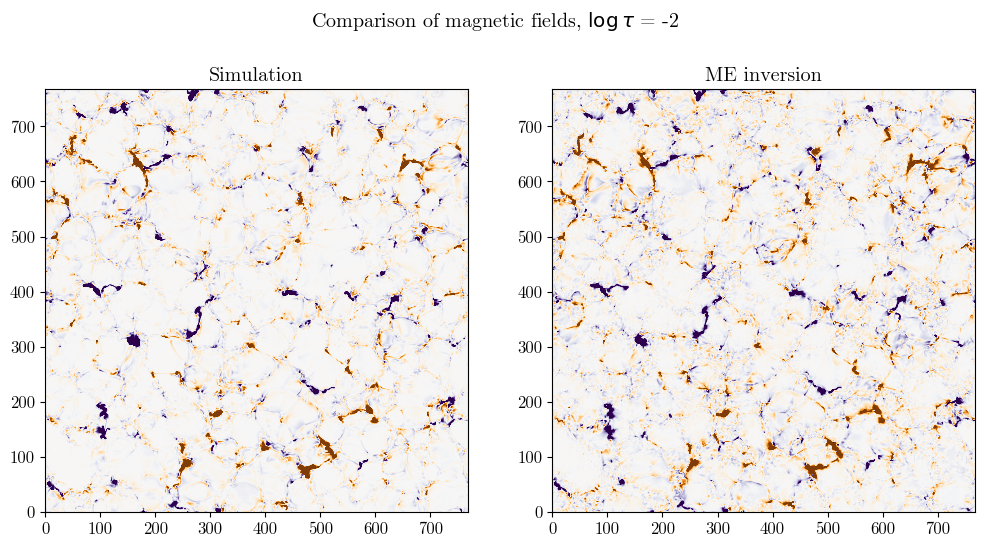

In [56]:
# Comparison of these two methods
fig = plt.figure(figsize = (12,6))
fig.suptitle("Comparison of magnetic fields, $\log\\tau$ = -2")
ax1 = fig.add_subplot(121)
ax1.imshow(Bz_tm2[0,:,:], origin='lower',cmap='PuOr', vmin = -200, vmax = 200)
ax1.set_title("Simulation") 

ax2 = fig.add_subplot(122)
ax2.imshow(Bz_ME[:,:], origin='lower', cmap='PuOr', vmin = -200, vmax = 200)
ax2.set_title("ME inversion") 

<h3>Let's average simulation $B_z$ over time</h3>

In [87]:
Bz_tm1_av = temporal_avg(Bz_tm1, 0, 90)
Bz_tm2_av = temporal_avg(Bz_tm2, 0, 90)

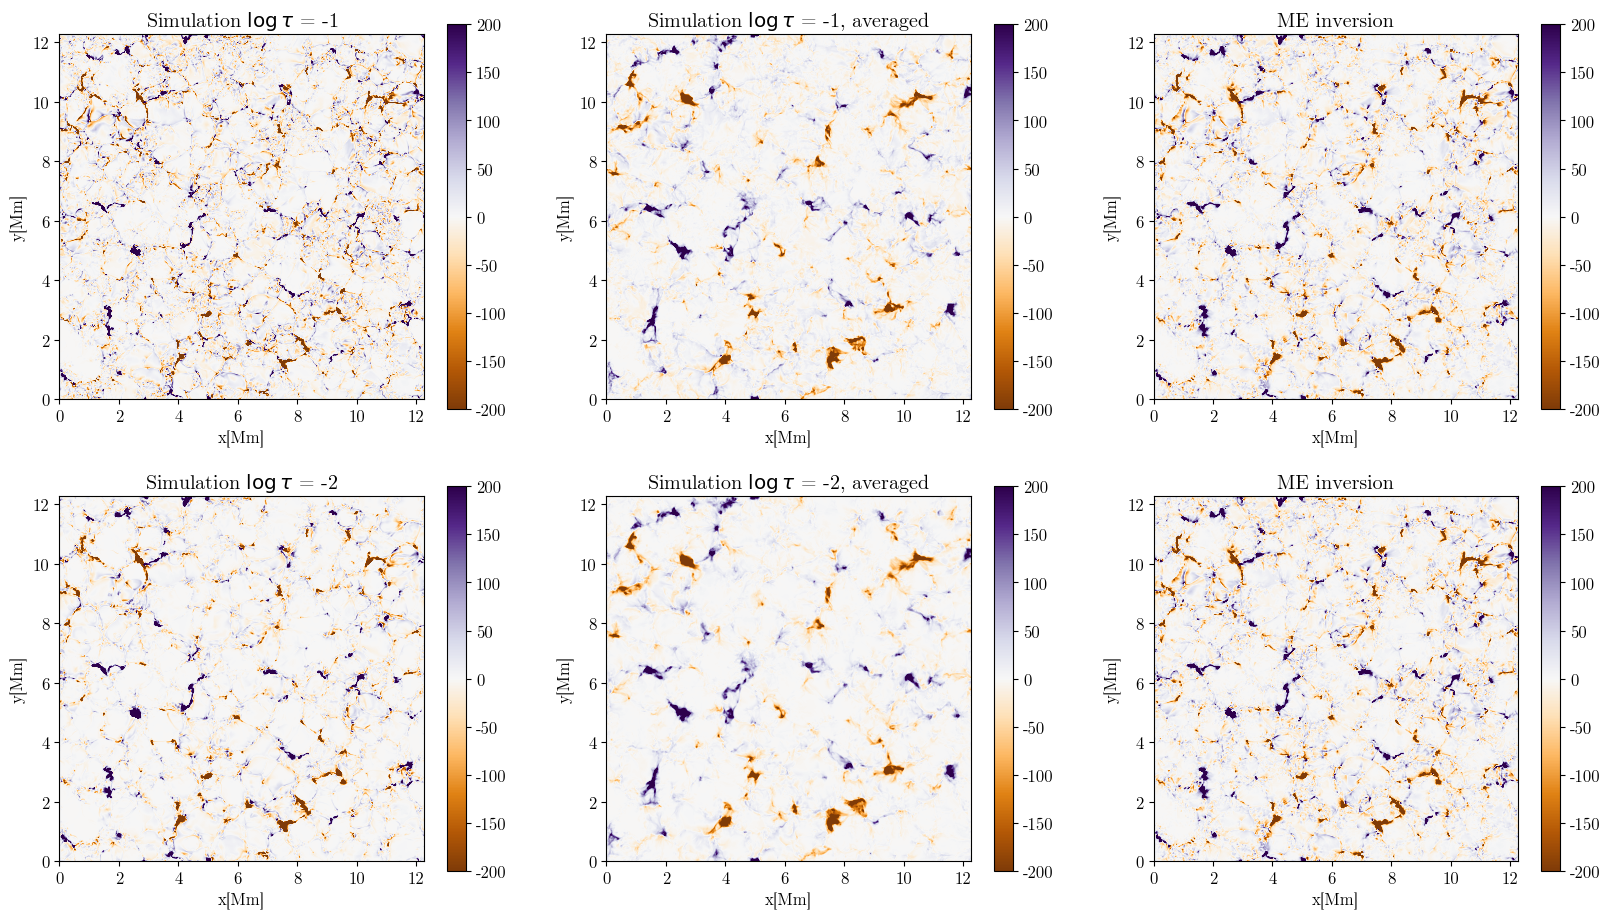

In [88]:
plt.figure(figsize = (20,11))
#plt.suptitle("Linear fit of FLCT Vx and convolved Vx from simulation for FHWM = {1200, 600, 300, 100}km")
# 4x3 plot, velicina A, velicina B, scatter A i B!!!
ax1 = plt.subplot2grid((2,3), (0,0))
ax1.set_title("Simulation $\log\\tau$ = -1")
ax1.set_xlabel("x[Mm]")
ax1.set_ylabel("y[Mm]")
im1 = ax1.imshow(Bz_tm1[0, :, :], origin='lower', cmap = "PuOr", extent = (0, 12.268, 0, 12.268), vmin = -200, vmax = 200)
plt.colorbar(im1)

ax2 = plt.subplot2grid((2,3), (0,1))
ax2.set_title("Simulation $\log\\tau$ = -1, averaged")
ax2.set_xlabel("x[Mm]")
ax2.set_ylabel("y[Mm]")
im2 = ax2.imshow(Bz_tm1_av[:, :], origin='lower', cmap = "PuOr", extent = (0, 12.268, 0, 12.268), vmin = -200, vmax = 200)
plt.colorbar(im2)

ax3 = plt.subplot2grid((2,3), (0,2))
ax3.set_title("ME inversion")
ax3.set_xlabel("x[Mm]")
ax3.set_ylabel("y[Mm]")
im3 = ax3.imshow(Bz_ME[:, :], origin='lower', cmap = "PuOr", extent = (0, 12.268, 0, 12.268), vmin = -200, vmax = 200)
plt.colorbar(im3)


ax4 = plt.subplot2grid((2,3), (1,0))
ax4.set_title("Simulation $\log\\tau$ = -2")
ax4.set_xlabel("x[Mm]")
ax4.set_ylabel("y[Mm]")
im4 = ax4.imshow(Bz_tm2[0, :, :], origin='lower', cmap = "PuOr", extent = (0, 12.268, 0, 12.268), vmin = -200, vmax = 200)
plt.colorbar(im4)

ax5 = plt.subplot2grid((2,3), (1,1))
ax5.set_title("Simulation $\log\\tau$ = -2, averaged")
ax5.set_xlabel("x[Mm]")
ax5.set_ylabel("y[Mm]")
im5 = ax5.imshow(Bz_tm2_av[:, :], origin='lower', cmap = "PuOr", extent = (0, 12.268, 0, 12.268), vmin = -200, vmax = 200)
plt.colorbar(im5)

ax6 = plt.subplot2grid((2,3), (1,2))
ax6.set_title("ME inversion")
ax6.set_xlabel("x[Mm]")
ax6.set_ylabel("y[Mm]")
im6 = ax6.imshow(Bz_ME[:, :], origin='lower', cmap = "PuOr", extent = (0, 12.268, 0, 12.268), vmin = -200, vmax = 200)
plt.colorbar(im6)


fig.tight_layout()
plt.savefig("Bz_SIM_Vs_ME.png", dpi = 70)

<h3>Correlation after averaging sim $B_z$ over 15 minutes</h3>

In [89]:
R_m1_av = pearsonr(Bz_tm1_av.flatten(), Bz_ME.flatten())
print(R_m1_av)
R_m2_av = pearsonr(Bz_tm2_av.flatten(), Bz_ME.flatten())
print(R_m2_av)

PearsonRResult(statistic=0.3821312682432085, pvalue=0.0)
PearsonRResult(statistic=0.39715177891598585, pvalue=0.0)


In [90]:
R_m1_mean = pearsonr(np.mean(Bz_tm1, axis = 0).flatten(), Bz_ME.flatten())
print(R_m1_mean)
R_m2_mean = pearsonr(np.mean(Bz_tm2, axis = 0).flatten(), Bz_ME.flatten())
print(R_m2_mean)

PearsonRResult(statistic=0.22110815935541184, pvalue=0.0)
PearsonRResult(statistic=0.2295296319829212, pvalue=0.0)
